# <font color=blueviolet>Multiclass Classification of wine quality </font>

<font color=black>The quality of the wine is an indicator of the true taste of the wine, which mainly depends on its chemical composition, but also on its color and aroma.<br>In this analysis, there are two sets of data related to red and white wine samples. The aim is to model wine quality based on personal taste using measured physico-chemical values.</font>

<font color=blue>In this second part of the project, different prediction models are trained and then compared with each other. The best model hyperparameters are fine-tuned and stored for later quality prediction of other data.</font><br><br>
<font color=black>The used modules in this project are first to be imported.</font>

In [1]:
# Importing Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import warnings

from sklearn.linear_model import LinearRegression
from imblearn.over_sampling import SMOTE
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.pipeline import Pipeline

warnings.filterwarnings('ignore')

2023-06-14 15:40:48.279997: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-06-14 15:40:48.280034: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


<font color=blue>There are two CSV files for red and white wine. These are read and stored as DataFrames and then merged after adding a column for wine type.</font>

In [2]:
# read the two files
red_wine = pd.read_csv("winequality-red.csv", sep=";")
white_wine = pd.read_csv("winequality-white.csv", sep=";")

# adding the type of wine
red_wine.insert(0, "type", 1)
white_wine.insert(0, "type", 0)

# merging the two files
wine = red_wine.append(white_wine, ignore_index=True)

## <font color=green>Classes balancing</font>

<font color=blue>EDA has shown that the classes are very unbalanced. And since some machine learning models don't have the class_weight='balanced' argument, they need an external class balancing tool like SMOTE.</font>

In [3]:
# classes balancing using SMOTE
def resample_data_smote(features, target):
    """Using SMOTE for the imbalanced data set.
        Returns balanced Data Set.
    Args: 
        features (pd.DataFrame) : unbalanced DataFrame
        target (pd.DataFrame) : unbalanced DataFrame
    Returns:
        features (pd.DataFrame) : balanced DataFrame
        target (pd.DataFrame) : balanced DataFrame
    """
    #initiate Smote
    smotesampler = SMOTE(random_state=42,k_neighbors=4)
    #fit and resample
    features, target = smotesampler.fit_resample(features, target)
    
    return features, target

## <font color=green>Data preparing</font>

<font color=blue>This part contains the following steps:</font><br>
<font color=blue>1) Calculating the median for each feature. These values will be applied in the function "clean_data".</font><br>
<font color=blue>2) Applying the log function to skewed features.</font><br>
<font color=blue>3) Defining the features and target dataframes.</font><br>
<font color=blue>4) Splitting the data into training and testing data.</font>

In [4]:
# These Dictionary will be used to replace NaNs in the dataframes
median_nan={}
for col_name in wine.columns[1:]:
    median_nan[col_name]=wine[col_name].median()

In [5]:
# Applying log function to the heavily skewed features
skewed_features=['residual sugar', 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'sulphates']
for feature in skewed_features:
    wine[feature] = np.log(wine[feature])

In [6]:
# define features and target
wine_features=wine.iloc[:,:-1]
wine_target=wine.iloc[:,-1]

In [7]:
# Train-test data Splitting
w_train_f, w_test_f, w_train_t, w_test_t = train_test_split(wine_features, wine_target, random_state=42, test_size=0.1)

## <font color=green>baseline models</font>

<font color=blue>Five models will be applied. The required model could be a classification or regression one, because the classes are ordered.</font>

### <font color=blueviolet>using Regression</font>

<font color=black>The first two models don't have the class_weight='balanced' argument, so SMOTE is applied to balance the classes.</font>

In [8]:
#apply SMOTE
f, t=resample_data_smote(w_train_f, w_train_t)

# features scaling
scaler = StandardScaler()
features_train_scaled = scaler.fit_transform(f)
features_test_scaled = scaler.transform(w_test_f)
features_train_scaled = pd.DataFrame(features_train_scaled,columns=w_train_f.columns)
features_test_scaled = pd.DataFrame(features_test_scaled,columns=w_test_f.columns)

# LinearRegression
model_reg=LinearRegression()
model_reg.fit(features_train_scaled,t)

# Calculate and save model performances 
score_sum=[]
target_pred=model_reg.predict(features_train_scaled)
target_pred=np.rint(target_pred)
train_accuracy=accuracy_score(t,target_pred)

target_pred=model_reg.predict(features_test_scaled)
target_pred=np.rint(target_pred)
test_accuracy=accuracy_score(w_test_t,target_pred)

score_sum.append({'name':'LinearRegression     ','train':train_accuracy,'test':test_accuracy})

<font color=blue>The second model will be the RandomForestRegressor.</font>

In [9]:
# RandomForestRegressor
model_rfr=RandomForestRegressor(random_state=42)
model_rfr.fit(features_train_scaled,t)

# Calculate and save model performances 
target_pred=model_rfr.predict(features_train_scaled)
target_pred=np.rint(target_pred)
train_accuracy=accuracy_score(t,target_pred)

target_pred=model_rfr.predict(features_test_scaled)
target_pred=np.rint(target_pred)
test_accuracy=accuracy_score(w_test_t,target_pred)

score_sum.append({'name':'RandomForestRegressor     ','train':train_accuracy,'test':test_accuracy})

<font color=orange>The other models have the argument "class_weight", which is far the better option for balancing the classes, and hence there is no more need for SMOTE.</font>

In [10]:
# features scaling
scaler = StandardScaler()
features_train_scaled = scaler.fit_transform(w_train_f)
features_test_scaled = scaler.transform(w_test_f)
features_train_scaled = pd.DataFrame(features_train_scaled,columns=w_train_f.columns)
features_test_scaled = pd.DataFrame(features_test_scaled,columns=w_test_f.columns)

<font color=black>The third model will be the LogisticRegression.</font>

In [11]:
# LogisticRegression
model_log=LogisticRegression(class_weight='balanced',multi_class='multinomial',random_state=42)
model_log.fit(features_train_scaled,w_train_t)

# Calculate and save model performances 
target_pred=model_log.predict(features_train_scaled)
train_accuracy=accuracy_score(w_train_t,target_pred)

target_pred=model_log.predict(features_test_scaled)
test_accuracy=accuracy_score(w_test_t,target_pred)

score_sum.append({'name':'LogisticRegression     ','train':train_accuracy,'test':test_accuracy})

### <font color=blueviolet>using Classification</font>

<font color=black>The last two models are pure classifiers.</font>

In [12]:
# RandomForestClassifier
model_rf=RandomForestClassifier(class_weight='balanced',random_state=42)
model_rf.fit(w_train_f,w_train_t)

# Calculate and save model performances 
target_pred=model_rf.predict(w_train_f)
train_accuracy=accuracy_score(w_train_t,target_pred)

target_pred=model_rf.predict(w_test_f)
test_accuracy=accuracy_score(w_test_t,target_pred)

score_sum.append({'name':'RandomForestClassifier     ','train':train_accuracy,'test':test_accuracy})

<font color=blue>The artificial neural network is the last model analyzed.</font>

In [13]:
# ANN
warnings.filterwarnings('ignore')
model_ann = Sequential() 
hidden_layer = Dense(units=50, activation= 'relu', input_dim=w_train_f.shape[1])
output_layer = Dense(units=1,activation= 'linear')
model_ann.add(hidden_layer)
model_ann.add(output_layer)
model_ann.compile(optimizer='adam', loss='mse', metrics=['mean_squared_error'])
model_ann.fit(w_train_f, w_train_t, epochs=50, batch_size=64,verbose=False)

# Calculate and save model performances 
target_pred=model_ann.predict(w_train_f)
target_pred=np.rint(target_pred)
train_accuracy=accuracy_score(w_train_t,target_pred)

target_pred=model_ann.predict(w_test_f)
target_pred=np.rint(target_pred)
test_accuracy=accuracy_score(w_test_t,target_pred)

score_sum.append({'name':'         ANN        ','train':train_accuracy,'test':test_accuracy})
warnings.filterwarnings('ignore')

2023-06-14 15:41:04.223769: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2023-06-14 15:41:04.224066: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-06-14 15:41:04.224081: W tensorflow/stream_executor/cuda/cuda_driver.cc:326] failed call to cuInit: UNKNOWN ERROR (303)
2023-06-14 15:41:04.224106: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (fac37137a31a): /proc/driver/nvidia/version does not exist
2023-06-14 15:41:04.224343: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the ap

<font color=blue>The table below summarizes the results of applying the five models.</font>

In [14]:
print('         Modell                          train accuracy             test accuracy')
print('---------------------------------------------------------------------------------')
for i in range(len(score_sum)):
    print('   {:40s}    {:.2f}                     {:.2f}'.format(score_sum[i]['name'],score_sum[i]['train'],score_sum[i]['test']))
    print('---------------------------------------------------------------------------------')

         Modell                          train accuracy             test accuracy
---------------------------------------------------------------------------------
   LinearRegression                            0.31                     0.40
---------------------------------------------------------------------------------
   RandomForestRegressor                       0.99                     0.66
---------------------------------------------------------------------------------
   LogisticRegression                          0.35                     0.33
---------------------------------------------------------------------------------
   RandomForestClassifier                      1.00                     0.70
---------------------------------------------------------------------------------
            ANN                                0.54                     0.55
---------------------------------------------------------------------------------


<font color=black>All models suffer from overfitting.<br>
RandomForestClassifier gives the best results and will therefore be optimized later.</font>

### <font color=blueviolet>features importance</font>

<font color=blue>The results of the RandomForestClassifier will be used to evaluate the relative importance of the features.</font>

In [15]:
# print ordered feature_importance 
feature_imp=pd.DataFrame(model_rf.feature_importances_, index=w_train_f.columns).sort_values(by=0, ascending=False)
feature_imp

,0
density,0.111433
alcohol,0.109481
chlorides,0.105375
free sulfur dioxide,0.094118
fixed acidity,0.088780
volatile acidity,0.087972
pH,0.087135
total sulfur dioxide,0.087087
residual sugar,0.080852
sulphates,0.072237


<font color=blue>These results can also be displayed as a chart.</font>

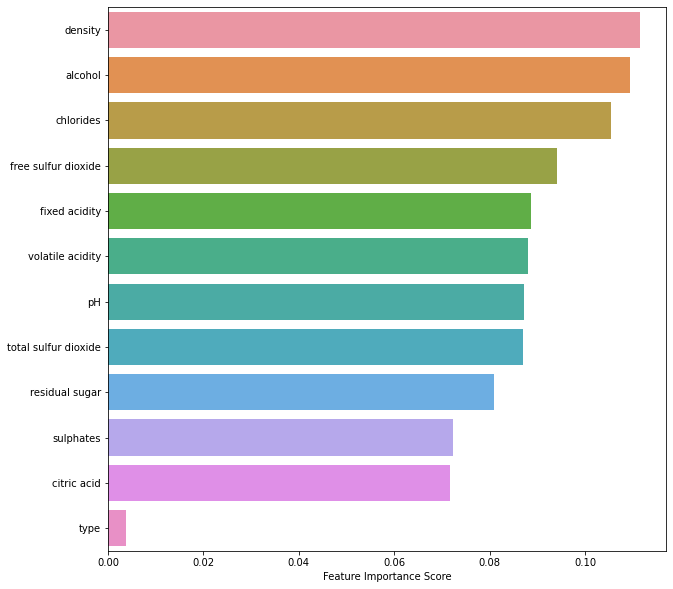

In [16]:
# showing the feature_importance chart
fig, ax = plt.subplots(figsize=[10,10])
sns.barplot(x=feature_imp[0], y=feature_imp.index)
sns.set(font_scale=1.5)
plt.xlabel('Feature Importance Score');

<font color=blue>Surprisingly, the type of wine hardly plays a role in the classification!</font>

### <font color=green>optimizing the final model with grid search</font>

<font color=black>The hyperparameter of the best model , "RandomForestClassifier", will be included in a pipeline along with  the Prinicipal Component Analysis, PCA. Then the Hyperparameters will tuned using GridSearchCV.</font>

In [17]:
# Omission of the feature "type" because it does not play a role in the classification
w_train_f = w_train_f.drop('type', axis=1)
w_test_f = w_test_f.drop('type', axis=1)

# Defining the appropriate pipeline
model_pipeline = Pipeline([('pca', PCA()),
                           ('rfc', RandomForestClassifier(class_weight='balanced',random_state=42))
                          ])

# n_components: number of kept components
# max_depth : Maximum number of levels in tree
# min_samples_leaf : Minimum number of samples required at each leaf node
search_space = {'pca__n_components' : [8,9,10],
                     'rfc__max_depth': np.geomspace(start=5, stop=50, num=10, dtype='int'),
                     'rfc__min_samples_leaf': np.geomspace(start=5, stop=50, num=10, dtype='int')
                    }
opt_model=GridSearchCV(estimator=model_pipeline,
                       param_grid=search_space,
                       scoring='accuracy',
                       cv=5,
                       n_jobs=-1
                      )

opt_model.fit(w_train_f, w_train_t)

# Calculate and save model performances 
print("accuracy ot the training set",opt_model.best_score_)
target_pred = opt_model.predict(w_test_f)
test_accuracy = accuracy_score(w_test_t, target_pred)
print("accuracy ot the testing set",test_accuracy)

accuracy ot the training set 0.6384495477908652
accuracy ot the testing set 0.6338461538461538


<font color=black>The accuracy of this multiclass classifier reaches 64% and does not suffer from overfitting.</font>

<font color=blue>In the following, the accuracy is calculated when the output is tolerated with 0, 1 or 2.</font>

In [18]:
# Accuracy with 0 tolerance
mask0=abs(w_test_t- target_pred)==0
print('with 0 quality tolerance is the accuracy {:.0f}%'.format(100*mask0.sum()/w_test_t.shape[0]))

# Accuracy with 1 tolerance
mask1=abs(w_test_t- target_pred)<=1
print('with 1 quality tolerance is the accuracy {:.0f}%'.format(100*mask1.sum()/w_test_t.shape[0]))

# Accuracy with 2 tolerance
mask2=abs(w_test_t- target_pred)<=2
print('with 2 quality tolerance is the accuracy {:.0f}%'.format(100*mask2.sum()/w_test_t.shape[0]))

with 0 quality tolerance is the accuracy 63%
with 1 quality tolerance is the accuracy 95%
with 2 quality tolerance is the accuracy 100%


<font color=blue>The best model is saved to a binary file using "pickle".</font>

In [19]:
# save the best model
pickle.dump(opt_model,open('opt_model.p','wb'))